In [1]:
import pandas as pd
import numpy as np

from shapleyx import rshdmr


from scipy.stats import qmc



from itertools import combinations

```
Results here 
```


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
def get_column_labels(n):
    column_labels = []
    for column_index in range(1,n+1):
        column_labels.append('X' + str(column_index)) 
    return column_labels

def ishigami(m):
    n=3
    #a=7
    #b=0.1
    a=2
    b=1
    sampler = qmc.Sobol(d=n, scramble=True, seed=123)
    S = sampler.random_base2(m=m)
    S=S*2*np.pi - np.pi
    Y = np.sin(S[  : ,0]) + a*(np.sin(S[  : ,1])**2) + b*S[  : ,2]**4 * np.sin(S[  : ,0])
    data = pd.DataFrame(S, columns=get_column_labels(n) ) 
    data['Y'] = Y
    return data

    
    

In [4]:
# m = 6 -> 64 samples
# m = 7 -> 128 samples
# m = 8 -> 256 samples
# m = 9 -> 512 samples
# m = 10 -> 1024 samples
# m = 11 -> 2048 samples 
# m = 12 -> 4096 samples
# m = 13 -> 8192 samples

m=9 
dataframe = ishigami(m)
print(len(dataframe), 'samples generated')

512 samples generated


In [5]:
dataframe


,X1,X2,X3,Y
0,0.607133,0.982525,-0.234066,1.956347
1,-1.743749,-2.409093,1.878209,-12.349466
2,-0.632661,2.509733,-2.727369,-32.610911
3,1.728958,-1.090534,1.032413,3.682519
4,2.709205,1.710561,3.031147,37.754160
...,...,...,...,...
507,2.715112,-0.379987,0.981532,1.072763
508,1.731493,2.519184,2.906674,72.128671
509,-0.619277,-1.093328,-1.261195,-0.471345
510,-1.766221,1.004507,0.416829,0.413748


Found a DataFrame

Transforming data to unit hypercube

X1: min = -3.1390334129985784, max = 3.1305404654960824
X2: min = -3.1393275590109404, max = 3.1356131924526647
X3: min = -3.1367545494347637, max = 3.133173829220537

Building basis functions

Number of terms of order 1 is 30
Number of terms of order 2 is 75

Running regression analysis

running ARD
0 0.57465027855868 inf
1 0.7935444434387675 38.09171822366659
2 0.9395567373627285 18.400014659699117
3 0.9696184888157717 3.199567440432019
4 0.9895185183784196 2.052356652867924
5 0.994999039185589 0.5538573261014419
6 0.9984941222710819 0.35126497090426306
7 0.9990823910658783 0.0589155991683077
8 0.9995729760331409 0.049103554586647793
finished
Iteration: 8, number of features in the model: 10
Iteration: 8, number of features in the model: 10
(8, 0.9995729760331409)
Fit Execution Time : 2.600706
--
 
 Model complete 
 

RS-HDMR model performance statistics

variance of data        : 555.836
sum of coefficients^2   : 539.535
varian

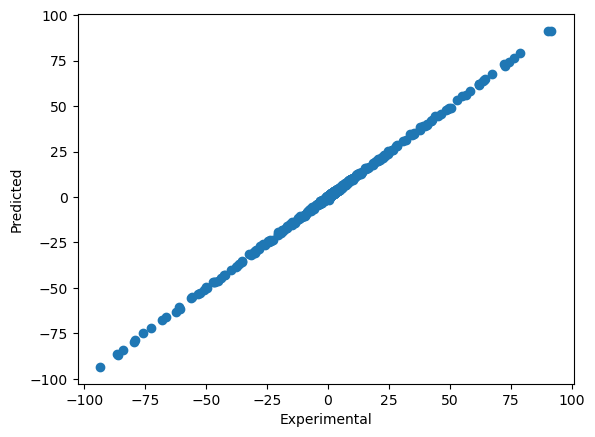


Running bootstrap resampling 1000 samples for 95.0% CI

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Completed bootstrap resampling


                  Completed all analysis
                 ------------------------

The moral virtues, then, are produced in us neither by
nature nor against nature. Nature, indeed, prepares in us
the ground for their reception, but their complete
formation is the product of habit.



In [6]:

model = rshdmr(dataframe,
               polys = [10, 5],
               n_iter = 250,
               method = 'ard_cv'
              )
               
sob, shap, total = model.run_all() 

In [7]:
sob

,derived_labels,index,lower,upper
0,X1,0.383175,0.381684,0.384825
1,X1_X3,0.615846,0.614161,0.617349
2,X2,0.000581,0.000511,0.000661


In [8]:
shap

,label,effect,scaled effect,lower,upper
0,X1,0.691098,0.691373,0.690589,0.692216
1,X2,0.000581,0.000581,0.000511,0.000661
2,X3,0.307923,0.308046,0.307201,0.308814


In [9]:
total

,label,total
0,X1,0.999022
1,X2,0.000581
2,X3,0.615846


In [ ]:
import math
import numpy as np
import scipy.special as sp
import pandas as pd 
from itertools import combinations 

def shift_legendre(n, x):
        """
        Computes the shifted Legendre polynomial of degree `n` evaluated at `x` and scales
        by a normalization factor.

        Args:
            n (int): Degree of the shifted Legendre polynomial.
            x (float or array-like): Point(s) at which the polynomial is evaluated.

        Returns:
            float or array-like: Value of the shifted Legendre polynomial at `x`.
        """
        normalization_factor = math.sqrt(2 * n + 1)
        polynomial_value = sp.eval_sh_legendre(n, x)
        return normalization_factor * polynomial_value


class legendre_expand():
    """
    Expands the input features using Legendre polynomials and generates polynomial combinations.
    
    This method performs the following steps:
    1. For each column in `self.X_T`, it computes Legendre polynomial expansions up to the order specified by `self.max_1st`.
       The results are stored in `self.X_T_L` as new columns, with column names in the format `<column>_<order>`.
    2. Generates polynomial combinations of the expanded features based on the polynomial orders specified in `self.polys`.
    3. Constructs a matrix of polynomial terms and concatenates them into a final DataFrame, which is stored in `self.X_T_L`.
    
    Attributes:
        self.primitive_variables (list): A list of primitive variable names used in the expansion.
        self.poly_orders (list): A list of polynomial orders corresponding to each primitive variable.
        self.X_T_L (pd.DataFrame): A DataFrame containing the expanded Legendre polynomial terms and their combinations.
    
    Steps:
        1. For each column in `self.X_T`:
            - Compute Legendre polynomial expansions for orders from 1 to `self.max_1st`.
            - Append the primitive variable name and polynomial order to `self.primitive_variables` and `self.poly_orders`.
            - Store the expanded terms in `self.X_T_L` with appropriate column headings.
        2. For each polynomial order in `self.polys`:
            - Generate a basis set of terms for the current polynomial order.
            - Create valid combinations of terms, ensuring that each combination contains unique primitive variables.
            - Compute the polynomial terms by multiplying the corresponding columns in `self.X_T_L`.
            - Store the computed terms in a matrix and concatenate them into the final DataFrame `generated_set`.
        3. Update `self.X_T_L` with the final generated set of polynomial terms.
    
    Notes:
        - The method assumes that `self.X_T`, `self.max_1st`, `self.polys`, and `self.Y` are properly initialized.
        - The `self.shift_legendre` method is used to compute the Legendre polynomial values.
        - The `combinations` function from the `itertools` module is used to generate term combinations.
        - The method prints the number of terms generated for each polynomial order.
    
    Example:
        If `self.X_T` contains columns 'A' and 'B', and `self.max_1st` is 2, the method will compute:
        - Legendre polynomial expansions for 'A_1', 'A_2', 'B_1', and 'B_2'.
        - If `self.polys` is [1, 2], it will generate:
            - First-order terms: 'A_1', 'B_1'.
            - Second-order terms: 'A_1*B_1', 'A_2*B_1', etc.
    """
    
        # Method implementation...
    def __init__(self, X, X_T, max_1st, polys, Y):
        """
        Initializes the legendre_expand class with the given parameters.

        Args:
            X (pd.DataFrame): Original input features.
            X_T (pd.DataFrame): Transformed input features.
            max_1st (int): Maximum order for the first set of Legendre polynomial expansions.
            polys (list): List of polynomial orders for generating combinations.
            Y (pd.Series): Target variable.

        """
        # Initialize attributes
        self.X = X 
        self.X_T = X_T
        self.max_1st = max_1st
        self.polys = polys
        self.Y = Y

        self.primitive_variables = []
        self.poly_orders = []
        self.X_T_L = pd.DataFrame()

    def do_expand(self):
        # Step 1: Compute Legendre polynomial terms
        for column in self.X_T:
            for n in range(1, self.max_1st + 1):
                self.primitive_variables.append(column)
                self.poly_orders.append(n)
                column_heading = f"{column}_{n}"
                self.X_T_L[column_heading] = self.X_T[column].apply(lambda x: shift_legendre(n, x))

        # Step 2: Generate polynomial combinations
        generated_set = pd.DataFrame()
        for order, max_poly_order in enumerate(self.polys, start=1):
            basis_set = [f"{x}_{j+1}" for x in self.X.columns for j in range(max_poly_order)]
            
            # Generate valid combinations
            combo_list = [
                combo for combo in combinations(basis_set, order)
                if len(set(term.split('_')[0] for term in combo)) == order
            ]
            
            total_combinations = len(combo_list)
            print(f"Number of terms of order {order} is {total_combinations}")

            # Compute polynomial terms
            matrix = np.zeros((len(self.Y), total_combinations))
            term_labels = []
            
            for term_index, combination in enumerate(combo_list):
                term_label = "*".join(combination)
                term_labels.append(term_label)
                
                # Multiply terms in the combination
                product = np.ones(len(self.Y))
                for term in combination:
                    product *= self.X_T_L[term]
                matrix[:, term_index] = product

            # Store results in a DataFrame
            em = pd.DataFrame(matrix, columns=term_labels)
            generated_set = pd.concat([generated_set, em], axis=1)

        # Step 3: Update the final DataFrame
        self.X_T_L = generated_set

    def get_expanded(self):
        return self.X_T_L
    
    def get_primitive_variables(self):
        return self.primitive_variables
    
    def get_poly_orders(self):
        return self.poly_orders 

In [ ]:
import math
import numpy as np
import scipy.special as sp
import pandas as pd 
from itertools import combinations, product 

def shift_legendre(n, x):
        """
        Computes the shifted Legendre polynomial of degree `n` evaluated at `x` and scales
        by a normalization factor.

        Args:
            n (int): Degree of the shifted Legendre polynomial.
            x (float or array-like): Point(s) at which the polynomial is evaluated.

        Returns:
            float or array-like: Value of the shifted Legendre polynomial at `x`.
        """
        normalization_factor = math.sqrt(2 * n + 1)
        polynomial_value = sp.eval_sh_legendre(n, x)
        return normalization_factor * polynomial_value

def get_hdmr_features(labels, poly_degrees):
    """Helper method to create meaningful feature names"""
    feature_names = []
    order = len(poly_degrees) 
    dims = len(labels)
    
    for current_order in range(1, order + 1):
        poly_degree = poly_degrees[current_order - 1] 
        for vars_ in combinations(range(dims), current_order):
            for degrees in product(range(1, poly_degree + 1), repeat=current_order):
                name_parts = [f'{labels[var]}_{degree}' for var, degree in zip(vars_, degrees)]
                feature_names.append('*'.join(name_parts))
    return feature_names
    
    # Polynomial chaos expansion

def generate_multi_indices_sum(total_degree, current_dim):
    if current_dim == 1:
        return [(total_degree,)]
    indices = []
    for i in range(total_degree + 1):
        for mi in generate_multi_indices_sum(total_degree - i, current_dim - 1):
            indices.append((i,) + mi)
    return indices

def generate_multi_indices(max_degree, dim):
    indices = []
    for total_degree in range(max_degree + 1):
        indices += generate_multi_indices_sum(total_degree, dim)
    return indices


def get_polynomial_chaos_features(labels, max_degree):
    feature_names = []
    dims = len(labels)
    for vars_ in generate_multi_indices(max_degree, dims):
        name_parts = [f'{labels[i]}_{degree}' for i, degree in enumerate(vars_) if degree > 0]
        feature_names.append('*'.join(name_parts))
    feature_names.pop(0)
    return feature_names


class legendre_expand():

    def __init__(self, X_T, polys):
        self.X_T = X_T
        self.polys = polys
        self.max_1st = max(polys)
        self.data_length = len(X_T) 
    

        self.primitive_variables = []
        self.poly_orders = []
        self.X_T_L = pd.DataFrame()
    
    def do_expand(self):
        # Step 1: Compute all of the required Legendre polynomial terms 
        for column in self.X_T:
            for n in range(1, self.max_1st + 1):
                self.primitive_variables.append(column)
                self.poly_orders.append(n)
                column_heading = f"{column}_{n}"
                self.X_T_L[column_heading] = self.X_T[column].apply(lambda x: shift_legendre(n, x))

    def build_basis_set(self):
        features = get_hdmr_features(self.X_T.columns, self.polys)
        num_features = len(features) 
        print(f"Total number of features in basis set is {num_features}")
        self.do_expand()
        basis_set = np.ones((self.data_length, num_features))
        for index, feature in enumerate(features):
            terms = feature.split('*')
            for term in terms:
                var, degree = term.split('_')
                basis_set[:, index] *= self.X_T_L[f"{var}_{degree}"]

        self.X_T_L = pd.DataFrame(basis_set, columns=features)


    def get_expanded(self):
        return self.X_T_L
    
    def get_primitive_variables(self):
        return self.primitive_variables
    
    def get_poly_orders(self):
        return self.poly_orders



In [57]:
tl = legendre_expand(model.X_T, polys=model.polys)
tl.build_basis_set()


Total number of features in basis set is 105


In [58]:
tl.X_T_L

,X1_1,X1_2,X1_3,X1_4,X1_5,X1_6,X1_7,X1_8,X1_9,X1_10,...,X2_4*X3_1,X2_4*X3_2,X2_4*X3_3,X2_4*X3_4,X2_4*X3_5,X2_5*X3_1,X2_5*X3_2,X2_5*X3_3,X2_5*X3_4,X2_5*X3_5
0,0.337803,-0.990454,-0.724936,0.716074,1.004917,-0.326562,-1.132902,-0.114279,1.088862,0.538504,...,-0.018575,-0.159163,0.042172,0.153955,-0.064991,-0.145555,-1.247203,0.330456,1.206390,-0.509270
1,-0.961120,-0.085248,1.072042,-1.094648,0.133656,0.948519,-1.183764,0.362090,0.783022,-1.230112,...,-0.985992,-0.083712,0.905088,1.161259,0.478134,1.445578,0.122731,-1.326963,-1.702539,-0.700999
2,-0.347215,-0.983245,0.742285,0.694101,-1.021294,-0.287129,1.137066,-0.167691,-1.070405,0.596361,...,1.045708,-0.984177,0.622480,-0.083586,-0.479643,1.992245,-1.875020,1.185927,-0.159245,-0.913799
3,0.957641,-0.092713,-1.076300,-1.087535,-0.117184,0.960082,1.176228,0.337457,-0.804132,-1.225644,...,-0.022435,0.029567,0.042082,-0.002203,-0.043649,-0.615256,0.810815,1.154028,-0.060427,-1.196990
4,1.499252,1.395035,0.854524,0.064012,-0.746701,-1.352294,-1.587701,-1.390127,-0.814500,-0.017752,...,-1.778872,-2.145778,-2.282303,-2.222268,-1.989522,-0.099296,-0.119777,-0.127398,-0.124046,-0.111055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,1.502516,1.405989,0.875123,0.091643,-0.719421,-1.335606,-1.591211,-1.418876,-0.866020,-0.081334,...,0.523918,-0.759956,-1.003605,0.140042,1.093880,-0.379938,0.551109,0.727799,-0.101556,-0.793265
508,0.959041,-0.089712,-1.074597,-1.090410,-0.123809,0.955461,1.179304,0.347378,-0.795695,-1.227534,...,-1.072124,-1.180210,-1.067454,-0.777564,-0.365039,-2.105350,-2.317601,-2.096180,-1.526918,-0.716835
509,-0.339820,-0.988926,0.728673,0.711406,-1.008502,-0.318153,1.133958,-0.125740,-1.085162,0.551052,...,0.030801,0.025529,-0.051591,0.015438,0.039397,0.747750,0.619777,-1.252471,0.374776,0.956437
510,-0.973537,-0.058391,1.056123,-1.119167,0.192661,0.905067,-1.207666,0.449324,0.703838,-1.239682,...,0.024627,-0.112677,-0.054750,0.098872,0.081179,0.260347,-1.191200,-0.578803,1.045256,0.858206


In [77]:


def generate_multi_indices_sum(total_degree, current_dim):
    if current_dim == 1:
        return [(total_degree,)]
    indices = []
    for i in range(total_degree + 1):
        for mi in generate_multi_indices_sum(total_degree - i, current_dim - 1):
            indices.append((i,) + mi)
    return indices

def generate_multi_indices(max_degree, dim):
    indices = []
    for total_degree in range(max_degree + 1):
        indices += generate_multi_indices_sum(total_degree, dim)
    return indices


def get_polynomial_chaos_features(labels, max_degree):
    feature_names = []
    dims = len(labels)
    for vars_ in generate_multi_indices(max_degree, dims):
        name_parts = [f'{labels[i]}_{degree}' for i, degree in enumerate(vars_) if degree > 0]
        feature_names.append('*'.join(name_parts))
    feature_names.pop(0)
    return feature_names


In [78]:
test  = get_polynomial_chaos_features(model.X_T.columns, 5)
test

['X3_1',
 'X2_1',
 'X1_1',
 'X3_2',
 'X2_1*X3_1',
 'X2_2',
 'X1_1*X3_1',
 'X1_1*X2_1',
 'X1_2',
 'X3_3',
 'X2_1*X3_2',
 'X2_2*X3_1',
 'X2_3',
 'X1_1*X3_2',
 'X1_1*X2_1*X3_1',
 'X1_1*X2_2',
 'X1_2*X3_1',
 'X1_2*X2_1',
 'X1_3',
 'X3_4',
 'X2_1*X3_3',
 'X2_2*X3_2',
 'X2_3*X3_1',
 'X2_4',
 'X1_1*X3_3',
 'X1_1*X2_1*X3_2',
 'X1_1*X2_2*X3_1',
 'X1_1*X2_3',
 'X1_2*X3_2',
 'X1_2*X2_1*X3_1',
 'X1_2*X2_2',
 'X1_3*X3_1',
 'X1_3*X2_1',
 'X1_4',
 'X3_5',
 'X2_1*X3_4',
 'X2_2*X3_3',
 'X2_3*X3_2',
 'X2_4*X3_1',
 'X2_5',
 'X1_1*X3_4',
 'X1_1*X2_1*X3_3',
 'X1_1*X2_2*X3_2',
 'X1_1*X2_3*X3_1',
 'X1_1*X2_4',
 'X1_2*X3_3',
 'X1_2*X2_1*X3_2',
 'X1_2*X2_2*X3_1',
 'X1_2*X2_3',
 'X1_3*X3_2',
 'X1_3*X2_1*X3_1',
 'X1_3*X2_2',
 'X1_4*X3_1',
 'X1_4*X2_1',
 'X1_5']

In [61]:
def generate_multi_indices(max_degree, dim):
    indices = []
    for total_degree in range(max_degree + 1):
        indices += generate_multi_indices_sum(total_degree, dim)
    return indices

In [62]:
generate_multi_indices(5, 3)

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (1, 0, 0),
 (0, 0, 2),
 (0, 1, 1),
 (0, 2, 0),
 (1, 0, 1),
 (1, 1, 0),
 (2, 0, 0),
 (0, 0, 3),
 (0, 1, 2),
 (0, 2, 1),
 (0, 3, 0),
 (1, 0, 2),
 (1, 1, 1),
 (1, 2, 0),
 (2, 0, 1),
 (2, 1, 0),
 (3, 0, 0),
 (0, 0, 4),
 (0, 1, 3),
 (0, 2, 2),
 (0, 3, 1),
 (0, 4, 0),
 (1, 0, 3),
 (1, 1, 2),
 (1, 2, 1),
 (1, 3, 0),
 (2, 0, 2),
 (2, 1, 1),
 (2, 2, 0),
 (3, 0, 1),
 (3, 1, 0),
 (4, 0, 0),
 (0, 0, 5),
 (0, 1, 4),
 (0, 2, 3),
 (0, 3, 2),
 (0, 4, 1),
 (0, 5, 0),
 (1, 0, 4),
 (1, 1, 3),
 (1, 2, 2),
 (1, 3, 1),
 (1, 4, 0),
 (2, 0, 3),
 (2, 1, 2),
 (2, 2, 1),
 (2, 3, 0),
 (3, 0, 2),
 (3, 1, 1),
 (3, 2, 0),
 (4, 0, 1),
 (4, 1, 0),
 (5, 0, 0)]